<a href="https://colab.research.google.com/github/anushiya-thevapalan/sentiment-analysis-imdb/blob/master/Sentiment_analysis_on_imdb_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on IMDB movie reviews

To perform the sentiment analysis the following files need to be downloaded.



1.   IMBD movie review dataset
2.   GloVe word embedding


## IMDB movie review dataset
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

## GloVe word embedding
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

http://nlp.stanford.edu/data/glove.6B.zip


## Downloading the IMDB movie review data and word embedding

In [1]:
# Download the glove word embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-30 02:09:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-30 02:09:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-30 02:09:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
# unzip the glove word embeddings
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
# Download the movie review dataset
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-08-30 02:16:12--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.7MB/s    in 4.7s    

2020-08-30 02:16:17 (17.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [4]:
# Unzip the movie review data
!tar xf aclImdb_v1.tar.gz

## Import required libraries

In [5]:
import os
import re
import string
import numpy as np
from keras import Model
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, concatenate, Bidirectional
from keras.layers.embeddings import Embedding
import matplotlib.pyplot as plt

## Loading and preprocessing data

In [6]:
def preprocess(txt):
    '''Preprocesses the text by removing HTML, XML, 
      punctuations and numbers, and returns the clean text
    '''

    def removeHTML(txt):
        #remove the Html in the text
        pattern = r'(<(?P<tag>[a-zA-Z0-9]+)>.*?</(?P=tag)>)'
        return re.sub(pattern, ' ', txt, flags=re.MULTILINE)

    def removeXml(txt):
        # remove the XML in the text
        pattern = r'/[a-zA-Z-_/]*\.xml'
        return re.sub(pattern, ' ', txt, flags=re.MULTILINE)

    def removeContinousFullstops(txt):
        # remove the Continous fullstop Eg: "......" with one fullstop.
        return re.sub('\.\.+', ' . ', txt,flags=re.MULTILINE)

    def removeNumbers(txt):
        # Remove the digits .
        pattern = r'\d+'
        return re.sub(pattern, ' . ', txt, flags=re.MULTILINE)

    def removePunctuationwithoutdot(txt):
        remove = string.punctuation
        remove = remove.replace(".", "")  # don't remove hyphens
        pattern = r"[{}]".format(remove)  # create the pattern
        return  re.sub(pattern, "", txt)

    txt=removeHTML(txt)
    txt =removeXml(txt)
    txt =removeContinousFullstops(txt)
    txt =removeNumbers(txt)
    txt =removePunctuationwithoutdot(txt)
    return txt

In [8]:
def loadData():
    '''
    Loads the data from the respective files and preprocesses the data using the preprocess() function
    '''
    # load File names
    trainPosFiles = os.listdir("./aclImdb/train/pos")
    trainNegFiles = os.listdir("./aclImdb/train/neg")
    testPosFiles = os.listdir("./aclImdb/test/pos")
    testNegFiles = os.listdir("./aclImdb/test/neg")

    #load positive, negative files from the directory

    trainPos = []
    trainNeg = []
    testPos = []
    testNeg = []

    for i in range(len(trainPosFiles)):
        with open("./aclImdb/train/pos/" + trainPosFiles[i], "r") as myfile:
            # Lower the text, preprocess the text
            line = preprocess((myfile.readlines()[0]).lower())
            trainPos.append(line)

    for i in range(len(trainNegFiles)):
        with open("./aclImdb/train/neg/" + trainNegFiles[i], "r") as myfile:
            # Lower the text, preprocess the text
            line = preprocess((myfile.readlines()[0]).lower())
            trainNeg.append(line)

    for i in range(len(trainPosFiles)):
        with open("./aclImdb/test/pos/" + testPosFiles[i], "r") as myfile:
            # Lower the text, preprocess the text
            line = preprocess((myfile.readlines()[0]).lower())
            testPos.append(line)

    for i in range(len(trainNegFiles)):
        with open("./aclImdb/test/neg/" + testNegFiles[i], "r") as myfile:
            # Lower the text, preprocess the text
            line = preprocess((myfile.readlines()[0]).lower())
            testNeg.append(line)

    #merge Positive and Negative Datasets
    trainX = trainPos + trainNeg
    testX = testPos + testNeg

    #preparing the labels for the dataset and  onehot encode
    trainY = to_categorical([1 if i < len(trainPos) else 0 for i in range(len(trainX))],num_classes=2)
    testY = to_categorical([1 if i < len(testPos) else 0 for i in range(len(testX))],num_classes=2)

    return np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

In [9]:
trainX, trainY, testX, testY = loadData()

In [10]:
print("Number of training samples : ", len(trainY))
print("Number of testing samples : ", len(trainY))

Number of training samples :  25000
Number of testing samples :  25000


## Load GloVe word embeddings

In [11]:
def read_glove_vecs(glove_file):
  '''
  reads the gloVe word embeddings
  '''
  with open(glove_file, 'r') as f:
      words = set()
      word_to_vec_map = {}
      for line in f:
          line = line.strip().split()
          curr_word = line[0]
          words.add(curr_word)
          word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

      i = 1
      words_to_index = {}
      index_to_words = {}
      for w in sorted(words):
          words_to_index[w] = i
          index_to_words[i] = w
          i = i + 1
  return words_to_index, index_to_words, word_to_vec_map


print("Loading Glove Vectors...")
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.200d.txt')

Loading Glove Vectors...


## Convert sentences to indices

In [12]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`.

    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]  # number of training examples

    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):  # loop over training examples

        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [w.lower() for w in X[i].split()]

        # Initialize j to 0
        j = 0

        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.

            try:
                X_indices[i, j] = word_to_index[w]
            except Exception as e:
                X_indices[i, j] = 0

            # Increment j to j + 1
            j += 1
            if j == 199:
                break

    return X_indices

## Creating an embedding layer and loading pre-trained GloVe vectors

In [13]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.

    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """

    vocab_len = len(word_to_index) + 1  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]  # define dimensionality of GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer


## Building the model

In [14]:
def buildModel(input_shape, word_to_vec_map, word_to_index):
    """
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """

    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32')

    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)

    # Add dropout with a probability of 0.5
    X = Dropout(0.2)(X)
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.2)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(2)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)

    return model

In [15]:
print("Building The Model...")

# Setting the maximum length to 200
maxLen = 200

model = buildModel((maxLen,), word_to_vec_map, word_to_index)
model.summary()
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Building The Model...
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 200)          80000200  
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 256)          336896    
_________________________________________________________________
dropout (Dropout)            (None, 200, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (No

## Training the model

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
X_train_indices = sentences_to_indices(trainX, word_to_index, maxLen)
history=model.fit(X_train_indices, trainY,validation_split=0.1, epochs=40 ,batch_size=50 , shuffle=True)

Epoch 1/40
450/450 [==============================] - 846s 2s/step - loss: 0.6237 - accuracy: 0.6536 - val_loss: 1.0887 - val_accuracy: 0.2340
Epoch 2/40
450/450 [==============================] - 887s 2s/step - loss: 0.4525 - accuracy: 0.7966 - val_loss: 0.4656 - val_accuracy: 0.8088
Epoch 3/40
450/450 [==============================] - 866s 2s/step - loss: 0.3863 - accuracy: 0.8358 - val_loss: 0.4826 - val_accuracy: 0.7980
Epoch 4/40
450/450 [==============================] - 876s 2s/step - loss: 0.3314 - accuracy: 0.8610 - val_loss: 0.3003 - val_accuracy: 0.8692
Epoch 5/40
450/450 [==============================] - 857s 2s/step - loss: 0.3005 - accuracy: 0.8768 - val_loss: 0.4688 - val_accuracy: 0.7944
Epoch 6/40
450/450 [==============================] - 840s 2s/step - loss: 0.2733 - accuracy: 0.8892 - val_loss: 0.4786 - val_accuracy: 0.8100
Epoch 7/40
450/450 [==============================] - 843s 2s/step - loss: 0.2406 - accuracy: 0.9044 - val_loss: 0.3107 - val_accuracy: 0.8680

## Visualizing the accuracy and loss

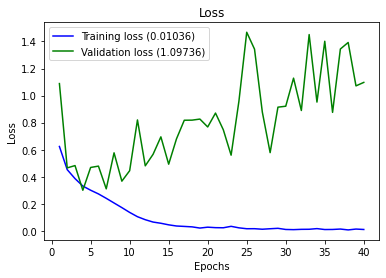

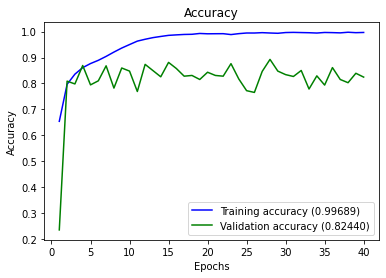

In [18]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

        ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b',
                 label='Training loss (' + str(str(format(history.history[l][-1], '.5f')) + ')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label='Validation loss (' + str(str(format(history.history[l][-1], '.5f')) + ')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b',
                 label='Training accuracy (' + str(format(history.history[l][-1], '.5f')) + ')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g',
                 label='Validation accuracy (' + str(format(history.history[l][-1], '.5f')) + ')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy.png', bbox_inches='tight')
    
plot_history(history)